In [30]:
# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
# from my_OIB_functions import importOIBgrav,importOIBatm,importOIBrad,mapplotOIBlocal
#from datetime import datetime, date, time
from pylab import *
pd.set_option("display.max_rows",30)
pd.set_option("precision",18)
pd.set_option('expand_frame_repr', False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
def importOIBrad(basedir,timedir,infile):
    datadir = 'IRMCR2'
    # infile = '2009_Antarctica_DC8'
    suffix = '.csv'
    
    ### Read ascii file as csv
    df = pd.read_csv(os.path.join(basedir, datadir, timedir, infile+suffix),
                     delimiter=",", na_values='-9999.00')
    df.rename(columns={'SURFACE': 'SURFACE_radar'}, inplace=True)
    
    ### DATETIME
    df['FRAMESTR'] = df['FRAME'].apply(str)
    df['DATE'] = pd.to_datetime(list(df.FRAMESTR.str[:8]), format='%Y%m%d')
    # del df['FRAMESTR']
    df['UNIX'] = df['DATE'].astype(np.int64) // 10 ** 9
    df['UNIX'] = df['UNIX'] + df['TIME'].astype(float64)
    df['iunix'] = pd.to_datetime(df['UNIX'], unit='s')
    df = df.set_index('iunix')
    df.index.astype(np.int64)[0:7] // 10 ** 9
    return df
            
def importOIBatm(basedir):
    datadir = 'ILATM2'
    infile = '2009_AN_NASA_ATM_all'
    suffix = '.txt'
    
    ### Read ascii file as csv
    headers = ('DATE','TIME','TIME2','LAT','LON','SURFACE_atm','SLOPESN','SLOPEWE','RMS','NUMUSED','NUMOMIT','DISTRIGHT','TRACKID')
    df = pd.read_csv(os.path.join(basedir,infile+suffix),delimiter=r"\s+",header=None)
    df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    del df['TIME2']
    
    ### do some DATETIME operations
    df['DATETIME'] = (df.DATE*1e5)+df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'],format='%Y%m%d')
    df['UNIX']=df['DATE'].astype(np.int64) // 10**9
    df['UNIX']=df['UNIX']+df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'],unit='s')
    df = df.set_index('iunix')
    return df
    
def importOIBgrav(basedir,timedir,infile):
    datadir = 'IGGRV1B'
    #infile = 'IGGRV1B_20091104_13100500_V016'
    #infile = 'IGGRV1B_20091031_11020500_V016'
    #infile = 'IGGRV1B_20091116_15124500_V016'
    
    suffix = '.txt'
    
    ### Read ascii file as csv
    headers = ('LAT','LON','DATE','DOY','TIME','FLT','PSX','PSY','WGSHGT','FX','FY','FZ','EOTGRAV','FACOR','INTCOR','FAG070','FAG100','FAG140','FLTENVIRO')
    print "Reading gravity file: %s" % infile+suffix    
    df = pd.read_csv(os.path.join(basedir, datadir, timedir, infile + suffix), delimiter=r"\s+", skiprows=70, header=None, names=headers)


    # headers = df.columns[1:df.shape[1]]
    # df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    # df.rename(columns={'LONG': 'LON'}, inplace=True)
    #df['ENVIRO'] = df.columns[[19]]
    #df.drop(df.columns['FLTENVIRO'],axis=1,inplace=True)
    
    ### do some DATETIME operations    
    df['DATETIME'] = (df.DATE*1e5)+df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'],format='%Y%m%d')
    df['UNIX']=df['DATE'].astype(np.int64) // 10**9
    df['UNIX']=df['UNIX']+df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'],unit='s')
    # print "First gravity records are :"
    # print df.iunix.dt.strftime('%Y-%m-%d %H:%M:%S.%f').head(5)
    df = df.set_index('iunix')
    df.index.astype(np.int64)[0:7] // 10 ** 9
    return df

In [75]:
#########################################################
### Read in data sets
# point to data directories
basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'
# if os.path.isdir('/Volumes/C/'):
#     basedir = '/Volumes/C/data/Antarctic/OIB/ATM/2009_AN_NASA_ATM'
# else:
#     basedir = '/Volumes/BOOTCAMP/data/Antarctic/OIB/ATM/2009_AN_NASA_ATM'

# Get date of gravity flight TODO make this user specified or for all flights
# infile = 'IGGRV1B_20091104_13100500_V016'
# subframe = 2009110401047

timedir = '2009.10.31'
# subframe = 2009103102018
subframe = 2009103102021

#infile = 'IGGRV1B_20091116_15124500_V016'
#subframe = 2009111601039

In [76]:
#########################################################
### Run functions to read in each data set
infile = 'IGGRV1B_20091031_11020500_V016'
grv = {}
grv = importOIBgrav(basedir,timedir,infile)
print(grv[['TIME','UNIX','FAG070']].head(5))

infile = 'IRMCR2_20091031_01'
rad = {}
rad = importOIBrad(basedir,timedir, infile)

# infile = 'IGGRV1B_20091031_11020500_V016'
# atm = {}
# atm = importOIBatm(basedir)

Reading gravity file: IGGRV1B_20091031_11020500_V016.txt


                        TIME          UNIX  FAG070
iunix                                             
2009-10-31 11:02:05  39725.0  1256986925.0     NaN
2009-10-31 11:02:05  39725.5  1256986925.5     NaN
2009-10-31 11:02:06  39726.0  1256986926.0     NaN
2009-10-31 11:02:06  39726.5  1256986926.5     NaN
2009-10-31 11:02:07  39727.0  1256986927.0     NaN


### `resample` data to 2 Hz
not done anymore

In [77]:
# #########################################################
print "******************"
print "Original Radar Data"
print "******************"
print(rad[['TIME','UNIX','ELEVATION']].head(8))

# ###Subsample all to 2 Hz (or "reindex")
rad2hz = {}
rad2hz = rad.resample('500L').mean().bfill()   #mean,median,mode???
# atm2hz = atm.resample('500L').mean()
rad2hz.rename(columns={'SURFACE': 'SURFACE_radar'}, inplace=True)


print "******************"
print "2 Hz Radar Data"
print "******************"
print(rad2hz[['TIME','UNIX','ELEVATION']].head(5))

******************
Original Radar Data
******************
                                         TIME                      UNIX                ELEVATION
iunix                                                                                           
2009-10-31 14:05:11  50711.840300000003480818  1.256997911840300083e+09  1259.331500000000005457
2009-10-31 14:05:11  50711.927199999998265412  1.256997911927200079e+09  1258.574900000000070577
2009-10-31 14:05:12  50712.014199999997799750  1.256997912014199972e+09  1257.818199999999933425
2009-10-31 14:05:12  50712.101099999999860302  1.256997912101099968e+09  1257.061400000000048749
2009-10-31 14:05:12  50712.188099999999394640  1.256997912188100100e+09  1256.304599999999936699
2009-10-31 14:05:12  50712.275099999998928979  1.256997912275099993e+09  1255.547700000000077125
2009-10-31 14:05:12  50712.362000000000989530  1.256997912361999989e+09  1254.790799999999990177
2009-10-31 14:05:12  50712.449000000000523869  1.256997912448999882e+

### Instead use `append`

In [78]:
rad.rename(columns={'LON': 'LON_radar'}, inplace=True)
rad.rename(columns={'LAT': 'LAT_radar'}, inplace=True)
rad.rename(columns={'TIME': 'TIME_radar'}, inplace=True)
df=grv.append(rad).sort_index()
df['ICEBASE'] = df['ELEVATION']-df['BOTTOM']
df['TOPOGRAPHY'] = df['ELEVATION']-df['SURFACE_radar']
df.dtypes

BOTTOM                  float64
DATE             datetime64[ns]
DATETIME                float64
DOY                     float64
ELEVATION               float64
EOTGRAV                 float64
FACOR                   float64
FAG070                  float64
FAG100                  float64
FAG140                  float64
FLT                     float64
FLTENVIRO               float64
FRAME                   float64
FRAMESTR                 object
FX                      float64
                      ...      
LAT                     float64
LAT_radar               float64
LON                     float64
LON_radar               float64
PSX                     float64
PSY                     float64
QUALITY                 float64
SURFACE_radar           float64
THICK                   float64
TIME                    float64
TIME_radar              float64
UNIX                    float64
WGSHGT                  float64
ICEBASE                 float64
TOPOGRAPHY              float64
dtype: o

In [109]:
df2hz = df.resample('500L').mean().bfill()

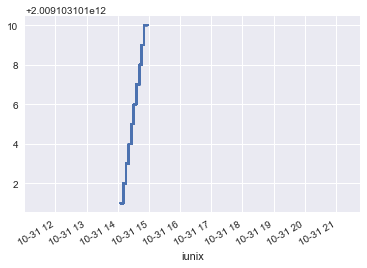

In [86]:
# df.plot(kind='scatter', x='LAT', y='LAT_radar')
# df.plot(kind='scatter', x='TIME', y='TIME_radar')

# df['TIME'].plot()
# df['TIME_radar'].plot()

df['FRAME'].plot()

In [66]:
# #########################################################
# ### append!
df = {}
df = pd.concat([grv, rad[['THICK','ELEVATION','FRAME','SURFACE_radar','BOTTOM','QUALITY']]], axis=1,join_axes=[grv.index])
# df = pd.concat([grv, rad2hz[['THICK','ELEVATION','FRAME','SURFACE_radar','BOTTOM','QUALITY']]], axis=1,join_axes=[grv.index])
# df = pd.concat([grv, rad2hz[['THICK','ELEVATION','FRAME','SURFACE_radar','BOTTOM','QUALITY']], atm2hz[['SURFACE_atm']]], axis=1,join_axes=[df.index])
# df['DAY'] = df.index.day
# df['HOUR'] = df.index.hour
df['ICEBASE'] = df['ELEVATION']-df['BOTTOM']
df['TOPOGRAPHY'] = df['ELEVATION']-df['SURFACE_radar']
# #df.drop['TIME2']
# ### Some plots
# #df['FAG070'].plot
# #fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(16, 12))
# #df['FAG070'].plot(ax=axes[0],legend=True);#axes[0,0].set_title('A');
# #df['ICEBASE'].plot(ax=axes[1],legend=True);#axes[0,0].set_title('A');

ValueError: Shape of passed values is (27, 150836), indices imply (27, 77342)

In [110]:
#########################################################
### subset one glacier profile by hand
df_sub = df2hz['2009-10-31 14:10:00':'2009-10-31 14:50:00']
#
# Larsen C
#dfsub = df['2009-11-04 23:00:00':'2009-11-04 23:15:00']
#dfsub = df.loc[df['FRAME'] == 2009110401046]
#dfsub = df.loc[df['FRAME'].isin(['2009110401047','2009110401048'])]
#
# THE ONE BELOW WORKS
# df_sub = df.query('(FRAME <= @subframe+2) & (FRAME >= @subframe-2)')
# df_sub = df.query('FRAME == 200910310101')
print(df_sub.head())

                                         BOTTOM          DATETIME    DOY               ELEVATION                 EOTGRAV                   FACOR                 FAG070                 FAG100                 FAG140   FLT          ...                                 PSY  QUALITY           SURFACE_radar  THICK      TIME                TIME_radar                      UNIX                  WGSHGT               ICEBASE            TOPOGRAPHY
iunix                                                                                                                                                                                                                                ...                                                                                                                                                                                                              
2009-10-31 14:10:00.000  491.670999999999992269  2009103151000.25  304.0  494.254299999999943793 -401.514999999999986358  

In [9]:
### using FX moving average
# window = 240 for plane maneuvers > 2 minutes
df['FX_MA'] = df['FX'].rolling(window=240, center=True).mean()
df_2 = df.query('(WGSHGT < 3000) & (FX_MA < 70000)')

### plots

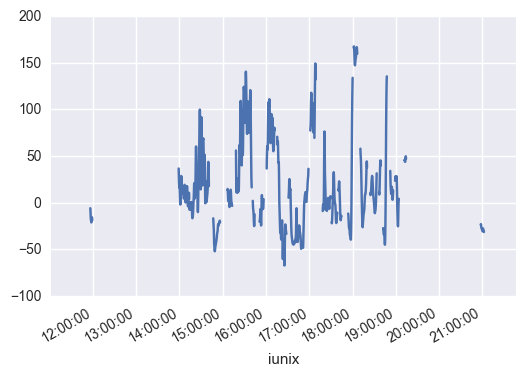

In [10]:
plt.figure(facecolor='w')
df['FAG070'].where((df['WGSHGT'] < 3000) & (df['FX_MA'] < 100000)).plot()

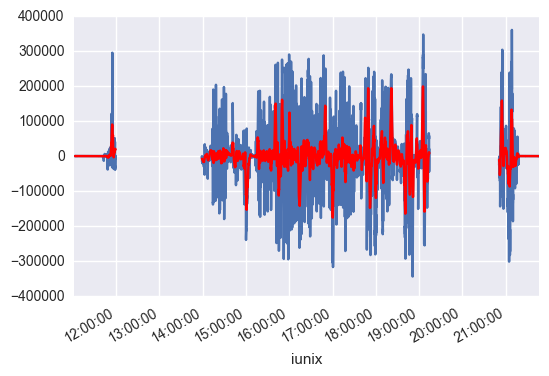

In [11]:
# overplot
plt.figure(facecolor='w')
df['FX'].where((df['WGSHGT'] < 3000)).plot()
df['FX_MA'].where((df['WGSHGT'] < 3000)).plot(color='red')

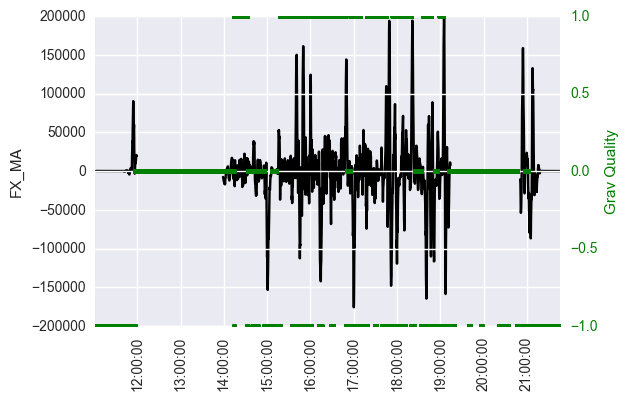

In [12]:
# setup a common plotting space
fig = plt.figure(facecolor='white')
plt.grid(b='on')
plt.xticks(rotation=90)

# ax1 is first
ax1 = fig.add_subplot(111)
ax1.plot(df['FX_MA'].where(df['WGSHGT'] < 3000), color='black')
ax1.set_ylabel('FX_MA')

# second plot is ax2
ax2 = ax1.twinx()
ax2.plot(df['FLTENVIRO'], '.g')
ax2.set_ylabel('Grav Quality', color='g')
# this is to change tick marks to green
for tl in ax2.get_yticklabels():
    tl.set_color('g')
    
# save figure to "figs" directory
# plt.savefig('figs/timeseries_WTMPvsDO_2014.png')

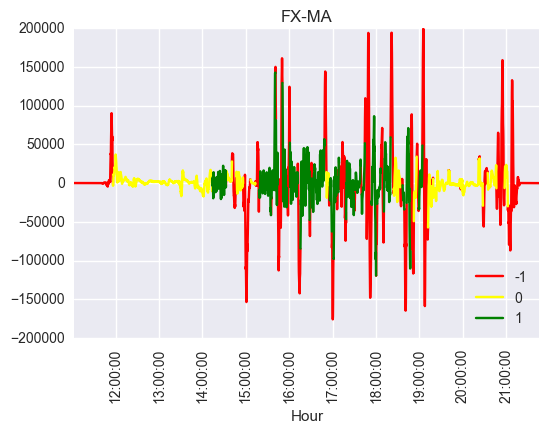

In [13]:
# overplot
plt.figure(facecolor='w')
plt.plot(df['FX_MA'].where((df['FLTENVIRO'] == -1)), color='red')
plt.plot(df['FX_MA'].where((df['FLTENVIRO'] == 0)), color='yellow')
plt.plot(df['FX_MA'].where((df['FLTENVIRO'] == 1)), color='green')
plt.title('FX-MA')
plt.xlabel("Hour")
plt.ylabel(" ")
plt.grid(b='on')
plt.xticks(rotation=90)
plt.legend(('-1', '0', '1'), loc='lower right')

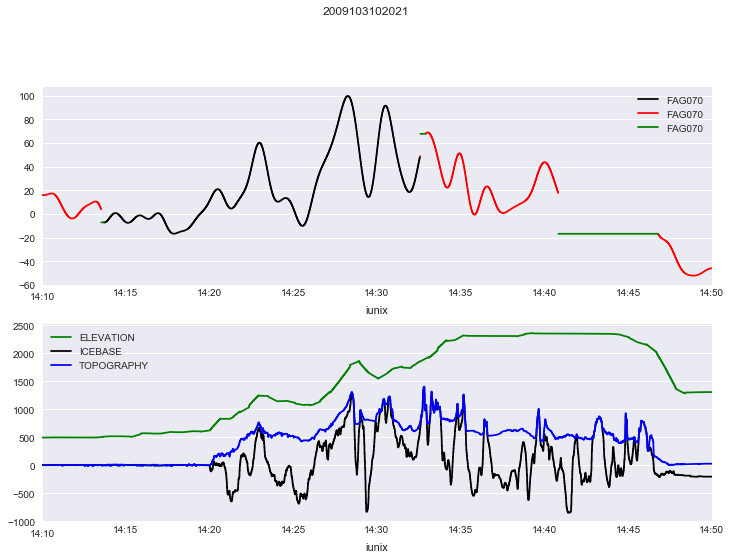

In [111]:
#########################################################
### LINE plots
#plt.figure(); dfsub.plot(subplots=True,layout=(4,8),figsize=(16, 12));
# more control
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12, 8))
df_sub['FAG070'].where((df_sub['FLTENVIRO'] == 1)).plot(ax=axes[0],legend='Good',style ='k-');#axes[0,0].set_title('A');
df_sub['FAG070'].where((df_sub['FLTENVIRO'] == 0)).plot(ax=axes[0],legend='Maybe',style ='r-');#axes[0,0].set_title('A');
df_sub['FAG070'].where((df_sub['FLTENVIRO'] == -1)).plot(ax=axes[0],legend='Maybe',style ='g-');#axes[0,0].set_title('A');
# df2hz['FAG140'].plot(ax=axes[0],legend=True,style ='r-');#axes[0,0].set_title('A');
df_sub['ELEVATION'].plot(ax=axes[1],legend=True,style ='g');#axes[0,0].set_title('A');
df_sub['ICEBASE'].plot(ax=axes[1],legend=True,style ='k');#axes[0,0].set_title('A');
df_sub['TOPOGRAPHY'].plot(ax=axes[1],legend=True,style ='b');#axes[0,0].set_title('A');
plt.suptitle(str(subframe), y=1.02)
plt.savefig('profile_'+str(subframe)+'_2hz.pdf',bbox_inches='tight')   # save the figure to file

In [15]:
print(df.columns[18:20])
print(df[:][18:20])

Index([u'FLTENVIRO', u'DATETIME'], dtype='object')
                           LAT        LON       DATE  DOY     TIME  FLT  \
iunix                                                                     
2009-10-31 11:02:14 -53.004554 -70.846768 2009-10-31  304  39734.0   11   
2009-10-31 11:02:14 -53.004554 -70.846768 2009-10-31  304  39734.5   11   

                            PSX         PSY  WGSHGT     FX  ...    \
iunix                                                       ...     
2009-10-31 11:02:14 -3929474.91  1364792.57   49.92  28.63  ...     
2009-10-31 11:02:14 -3929474.91  1364792.57   49.92  30.41  ...     

                             UNIX  THICK  ELEVATION  FRAME  SURFACE_radar  \
iunix                                                                       
2009-10-31 11:02:14  1.256987e+09    NaN        NaN    NaN            NaN   
2009-10-31 11:02:14  1.256987e+09    NaN        NaN    NaN            NaN   

                     BOTTOM  QUALITY  ICEBASE  TOPOGRAPHY  FX_

### mapplot

In [ ]:
mapplotOIBlocal(df['LON'], df['LAT'], df['FAG070'].where((df['WGSHGT'] < 3000)), 'FAG070 (below 3000)','mGal',[-50,150],cm.RdBu)

In [ ]:
mapplotOIBlocal(df['LON'], df['LAT'], df['FX_MA'].where((df['WGSHGT'] < 3000)), 'FX_MA','mGal',[-100000,100000],cm.RdBu)

In [96]:
plt.figure(facecolor='w')
mapplotOIBlocal(df_sub['LON'], df_sub['LAT'], df_sub['FAG070'], 'FAG070 (below 3000, small FX)','mGal',[-50,150],cm.RdBu)

ImportError: dlopen(/usr/local/lib/python2.7/site-packages/_geoslib.so, 2): Library not loaded: /usr/local/opt/geos/lib/libgeos-3.5.0.dylib
  Referenced from: /usr/local/lib/python2.7/site-packages/_geoslib.so
  Reason: image not found